# Strategy making

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from itertools import product

In [179]:
PRED_CSV = "ensemble_predictions.csv"
PRICES_CSV = "prices5.csv"
BM_CSV = "benchmark.csv"

ASSETS = ['NVDA', 'MU', 'AVGO', 'AMD', 'AMAT']
BM1, BM2 = 'SMH', 'SPY'

START_FILTER = '2025-04-29 15:59:00'
END_FILTER = '2025-10-28 15:58:00'

COST_PER_TURN = 0.0005
K_GRID = [0.0, 0.25, 0.5, 1.0, 1.5,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]
CALIB_RATIO = 0.1
ROLL_STD_WIN = 300
FREQ_PER_DAY = 390
DAYS_PER_YEAR = 252

In [180]:
def periods_per_year(): return FREQ_PER_DAY * DAYS_PER_YEAR
def ann_return_from_minute(r): return r.mean() * periods_per_year()
def ann_vol_from_minute(r): return r.std() * np.sqrt(periods_per_year())
def sharpe_from_minute(r):
    v = ann_vol_from_minute(r)
    return ann_return_from_minute(r) / v if v != 0 else np.nan
def max_drawdown(cum):
    equity_curve = 1 + cum
    peak = equity_curve.cummax()
    dd = (equity_curve - peak) / peak
    result = dd.min()
    return result if np.isfinite(result) else 0.0

In [181]:
print("Reading CSVs...")
df_pred_raw = pd.read_csv(PRED_CSV, parse_dates=['datetime'])
df_price_raw = pd.read_csv(PRICES_CSV, parse_dates=['datetime'])
df_bm_raw = pd.read_csv(BM_CSV, parse_dates=['datetime'])

df_pred_raw = df_pred_raw[df_pred_raw['symbol'].isin(ASSETS)].copy()
df_price_raw = df_price_raw[df_price_raw['symbol'].isin(ASSETS)].copy()
df_bm_raw = df_bm_raw[df_bm_raw['symbol'].isin([BM1, BM2])].copy()

df_pred = df_pred_raw.pivot(index='datetime', columns='symbol', values='ensemble_predicted_log_return')
df_pred.columns = [f'logret_{c}' for c in df_pred.columns]
df_w = df_pred_raw.pivot(index='datetime', columns='symbol', values='ensemble_weight_relative')
df_w.columns = [f'w_{c}' for c in df_w.columns]

df = pd.concat([df_pred, df_w], axis=1)
df = df.reindex(pd.to_datetime(df.index)).sort_index()

for s in ASSETS:
    if f'logret_{s}' not in df.columns:
        df[f'logret_{s}'] = np.nan
    if f'w_{s}' not in df.columns:
        df[f'w_{s}'] = np.nan

Reading CSVs...


In [182]:
price_open = df_price_raw.pivot(index='datetime', columns='symbol', values='open').sort_index()
price_close = df_price_raw.pivot(index='datetime', columns='symbol', values='close').sort_index()

for s in ASSETS:
    if s in price_open.columns:
        df[f'open_{s}'] = price_open[s]
    if s in price_close.columns:
        df[f'close_{s}'] = price_close[s]

bm_close = df_bm_raw.pivot(index='datetime', columns='symbol', values='close').sort_index()
df = df.join(bm_close.reindex(df.index))

req_cols = [f'open_{ASSETS[0]}', f'close_{ASSETS[0]}']
df = df.dropna(subset=req_cols).copy()

## Realized Return

In [183]:
for s in ASSETS:
    df[f'open_next_{s}'] = df[f'open_{s}'].shift(-1)
    df[f'close_next_{s}'] = df[f'close_{s}'].shift(-1)
    # real_ret_s in line t stores t+1 (open->close) return
    df[f'real_ret_{s}'] = df[f'close_next_{s}'] / df[f'open_next_{s}'] - 1

# benchmark minute return (t+1)
for bm in [BM1, BM2]:
    if bm in df.columns:
        df[f'ret_{bm}'] = df[bm].shift(-1) / df[bm] - 1
    else:
        df[f'ret_{bm}'] = np.nan

df = df.dropna(subset=[f'real_ret_{ASSETS[0]}', f'ret_{BM1}', f'ret_{BM2}']).copy()

print(f"Data before filtering: {df.index.min()} to {df.index.max()}")
df = df.loc[START_FILTER:END_FILTER].copy()
if df.empty:
    raise ValueError("No data remaining after applying time filter. Check START_FILTER/END_FILTER.")
print(f"Data filtered: {df.index.min()} to {df.index.max()}. Total {len(df)} minutes.")

Data before filtering: 2025-04-29 15:59:00 to 2025-10-27 15:58:00
Data filtered: 2025-04-29 15:59:00 to 2025-10-27 15:58:00. Total 17915 minutes.


In [184]:
# simple predict return
for s in ASSETS:
    df[f'predret_{s}'] = np.expm1(df[f'logret_{s}'])

w_cols = [f'w_{s}' for s in ASSETS]
df[w_cols] = df[w_cols].fillna(method='ffill').fillna(1.0/len(ASSETS))

# realized return（open->close next minute）
df['model_combo_real_ret'] = 0.0
for s in ASSETS:
    df['model_combo_real_ret'] += df[f'w_{s}'] * df[f'real_ret_{s}']

df['model_combo_pred_ret'] = 0.0
for s in ASSETS:
    df['model_combo_pred_ret'] += df[f'w_{s}'] * df[f'predret_{s}']

/var/folders/6w/ztz7qpwn439gp8lrrk1c9g7m0000gn/T/ipykernel_29716/3667343238.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[w_cols] = df[w_cols].fillna(method='ffill').fillna(1.0/len(ASSETS))


## Automatic threshold calculation

In [185]:
df['pred_std_row'] = df[[f'predret_{s}' for s in ASSETS]].std(axis=1).fillna(0.0)
# for pred_std_row do a  rolling
df['pred_std'] = df['pred_std_row'].rolling(window=ROLL_STD_WIN, min_periods=5).mean().fillna(method='ffill').fillna(0.0)

# Calibration interval (using 10% of the filtered data)
n = len(df)
calib_n = max(50, int(n * CALIB_RATIO))
calib_df = df.iloc[:calib_n]
calib_idx = calib_df.index

best_K = K_GRID[0]
best_shp = -np.inf

print("Calibrating K...")
preds_calib = calib_df[[f'predret_{s}' for s in ASSETS]].values
baseline_ws_calib = calib_df[[f'w_{s}' for s in ASSETS]].values
# real_rets_calib in line i stores i+1 return
real_rets_calib = calib_df[[f'real_ret_{s}' for s in ASSETS]].values
pred_std_calib = calib_df['pred_std'].values

for K in K_GRID:
    pnl_list = []
    prev_pos = np.zeros(len(ASSETS))

    for i in range(calib_n):
        thr = COST_PER_TURN + K * pred_std_calib[i]
        preds = preds_calib[i]
        baseline_ws = baseline_ws_calib[i]

        sel_mask = preds > thr
        if sel_mask.sum() == 0:
            tgt_w = np.zeros(len(ASSETS))
        else:
            base_selected = baseline_ws * sel_mask
            if base_selected.sum() == 0:
                base_selected = sel_mask.astype(float)
            tgt_w = base_selected / base_selected.sum()

        pos_now = tgt_w # position is held at t+1 (i+1)

        # PnL[t] = Pos[t] * Ret[t]
        # t position prev_pos
        # t return rets_t = real_rets_calib[i-1]
        if i == 0:
            pnl_gross = 0.0 # no position held in the first minute.
        else:
            rets_t = real_rets_calib[i-1]
            if np.isnan(rets_t).any():
                pnl_gross = 0.0
            else:
                pnl_gross = (prev_pos * rets_t).sum()

        pnl_list.append(pnl_gross)
        prev_pos = pos_now

    pnl_series = pd.Series(pnl_list[1:])
    shp = sharpe_from_minute(pnl_series)

    if shp > best_shp:
        best_shp = shp
        best_K = K

print(f"Calibrated K = {best_K}, calibration Sharpe = {best_shp:.4f}")
df['threshold_t'] = COST_PER_TURN + best_K * df['pred_std']

Calibrating K...


/var/folders/6w/ztz7qpwn439gp8lrrk1c9g7m0000gn/T/ipykernel_29716/2943259900.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['pred_std'] = df['pred_std_row'].rolling(window=ROLL_STD_WIN, min_periods=5).mean().fillna(method='ffill').fillna(0.0)


Calibrated K = 1.5, calibration Sharpe = 17.2798


## Strategy Realization

In [186]:
print("Running strategy (Vectorized)...")

for s in ASSETS:
    df[f'real_ret_t_{s}'] = df[f'real_ret_{s}'].shift(1)

for bm in [BM1, BM2]:
    df[f'ret_t_{bm}'] = df[f'ret_{bm}'].shift(1)

df = df.dropna(subset=[f'real_ret_t_{ASSETS[0]}', f'ret_t_{BM1}']).copy()
if df.empty:
    raise ValueError("No data remaining after PnL shift. Check data range.")

print(f"Running strategy on {len(df)} minutes...")

# 1. position (pos_now)
pos_cols = [f'pos_{s}' for s in ASSETS]
preds_df = df[[f'predret_{s}' for s in ASSETS]]
baseline_ws_df = df[[f'w_{s}' for s in ASSETS]]
# (N_rows, 1)
threshold_df = df['threshold_t'].values.reshape(-1, 1)

# (N_rows, N_assets)
sel_mask = preds_df.values > threshold_df
base_selected = baseline_ws_df.values * sel_mask
base_selected_sum = base_selected.sum(axis=1, keepdims=True)

# fallback
fallback_mask = (base_selected_sum == 0) & (sel_mask.sum(axis=1, keepdims=True) > 0)
sel_mask_float = sel_mask.astype(float)
# 应用 fallback
base_selected = np.where(fallback_mask, sel_mask_float, base_selected)
base_selected_sum = base_selected.sum(axis=1, keepdims=True)

# normalization
pos_now_df = pd.DataFrame(
    np.divide(base_selected, base_selected_sum,
              out=np.zeros_like(base_selected),
              where=(base_selected_sum != 0)),
    index=df.index,
    columns=pos_cols
)
df = pd.concat([df, pos_now_df], axis=1)

Running strategy (Vectorized)...
Running strategy on 17914 minutes...


In [187]:
# 2. PnL and  Cost
prev_pos_df = pos_now_df.shift(1).fillna(0.0)
real_ret_t_df = df[[f'real_ret_t_{s}' for s in ASSETS]]

df['pnl_gross'] = (prev_pos_df.values * real_ret_t_df.values).sum(axis=1)

df['turnover'] = np.abs(pos_now_df.values - prev_pos_df.values).sum(axis=1)
df['costs'] = COST_PER_TURN * df['turnover']
df['pnl'] = df['pnl_gross'] - df['costs']

# 3. culmulate
df = df.iloc[1:].copy()
df['cum_net'] = (1 + df['pnl']).cumprod() - 1
df['cum_gross'] = (1 + df['pnl_gross']).cumprod() - 1

print("Strategy run complete (Vectorized).")

Strategy run complete (Vectorized).


## Performance Metrics

In [188]:
print("Computing performance metrics...")
strategy_ret = df['pnl']
ann_ret = ann_return_from_minute(strategy_ret)
ann_vol = ann_vol_from_minute(strategy_ret)
shp = sharpe_from_minute(strategy_ret)
avg_turn = df['turnover'].mean()
maxdd = max_drawdown(df['cum_net'])

# benchmark metrics (minute-level)
bm1_ret = df[f'ret_t_{BM1}']
bm2_ret = df[f'ret_t_{BM2}']
ann_ret_bm1 = ann_return_from_minute(bm1_ret)
ann_vol_bm1 = ann_vol_from_minute(bm1_ret)
ann_ret_bm2 = ann_return_from_minute(bm2_ret)
ann_vol_bm2 = ann_vol_from_minute(bm2_ret)

# excess vs SMH
df['excess_vs_smh'] = df['pnl'] - bm1_ret
ann_excess_smh = ann_return_from_minute(df['excess_vs_smh'])

# regressions for alpha/beta (strategy pnl on BM returns)
def ols_reg(y, x):
    x = sm.add_constant(x)
    model = sm.OLS(y, x, missing='drop').fit()
    return model

reg_smh = ols_reg(df['pnl'], bm1_ret)
reg_spy = ols_reg(df['pnl'], bm2_ret)

Computing performance metrics...


In [189]:
summary = {
    'AnnReturn_strategy': ann_ret,
    'AnnVol_strategy': ann_vol,
    'Sharpe_strategy': shp,
    'AvgTurnover_per_min': avg_turn,
    'MaxDrawdown': maxdd,
    'AnnExcess_vs_SMH': ann_excess_smh,
    'AnnReturn_SMH': ann_ret_bm1,
    'AnnVol_SMH': ann_vol_bm1,
    'AnnReturn_SPY': ann_ret_bm2,
    'AnnVol_SPY': ann_vol_bm2,
    'Calibrated_K': best_K
}

print("\n=== Performance summary ===")
for k, v in summary.items():
    if isinstance(v, float):
        print(f"{k:25s} : {v:.6f}")
    else:
        print(f"{k:25s} : {v}")

print(f"\nRegression vs {BM1} (alpha, beta, t-stats):")
print(reg_smh.summary().tables[1])
print(f"\nRegression vs {BM2} (alpha, beta, t-stats):")
print(reg_spy.summary().tables[1])


=== Performance summary ===
AnnReturn_strategy        : -9.538817
AnnVol_strategy           : 0.105500
Sharpe_strategy           : -90.415449
AvgTurnover_per_min       : 0.204368
MaxDrawdown               : -0.824425
AnnExcess_vs_SMH          : -12.566552
AnnReturn_SMH             : 3.027735
AnnVol_SMH                : 0.438516
AnnReturn_SPY             : 1.203747
AnnVol_SPY                : 0.191858
Calibrated_K              : 1.500000

Regression vs SMH (alpha, beta, t-stats):
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.763e-05   2.51e-06    -38.932      0.000      -0.000   -9.27e-05
ret_t_SMH      0.0185      0.002     10.329      0.000       0.015       0.022

Regression vs SPY (alpha, beta, t-stats):
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [195]:
df_out_cols = ['pnl', 'pnl_gross', 'costs', 'turnover', 'cum_net', 'model_combo_real_ret'] + \
              pos_cols + [f'predret_{s}' for s in ASSETS] + \
              [f'real_ret_t_{s}' for s in ASSETS] + [f'w_{s}' for s in ASSETS]
df_out = df[df_out_cols].copy()
df_out.to_csv("strategy_results.csv", index=True)
pd.DataFrame([summary]).to_csv("performance_summary.csv", index=False)
print("Saved strategy_results.csv and performance_summary.csv")

Saved strategy_results.csv and performance_summary.csv


## Visualization

Plotting...


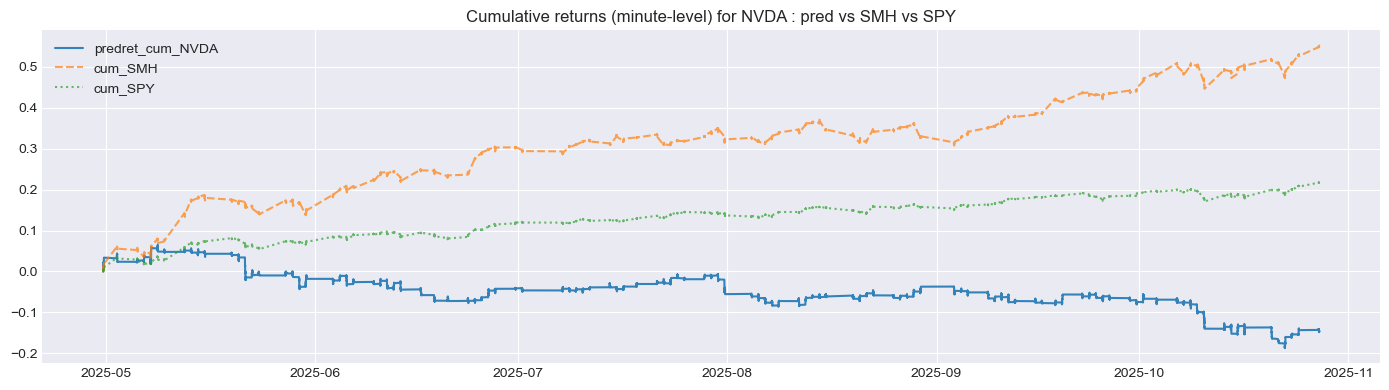

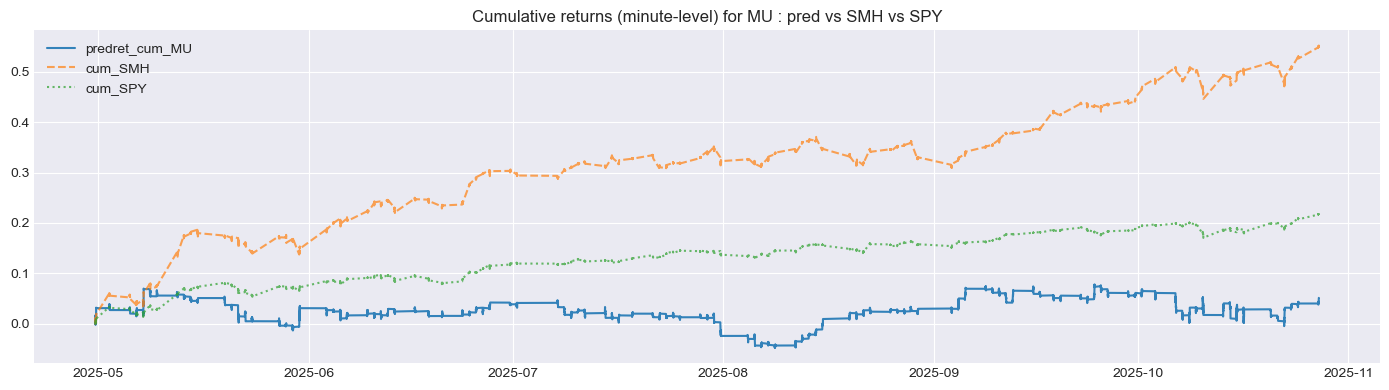

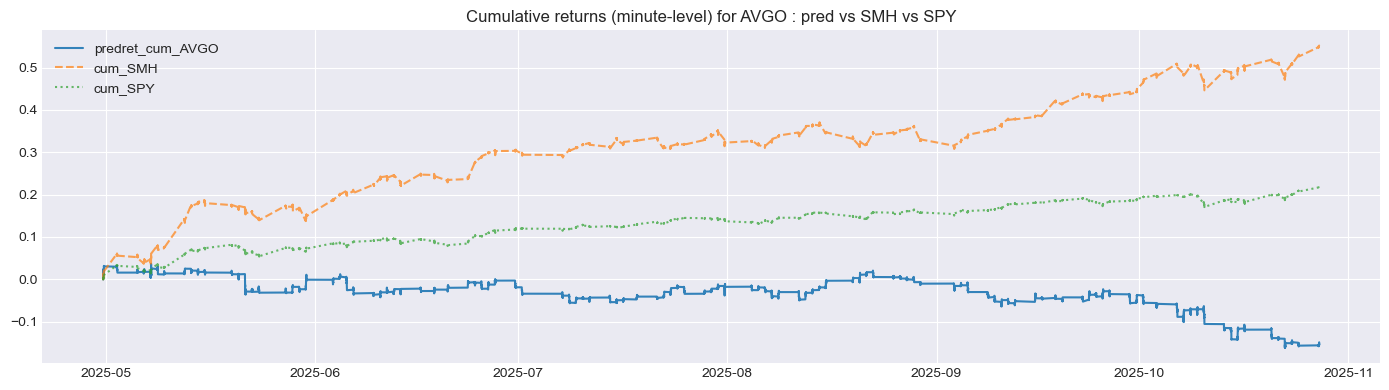

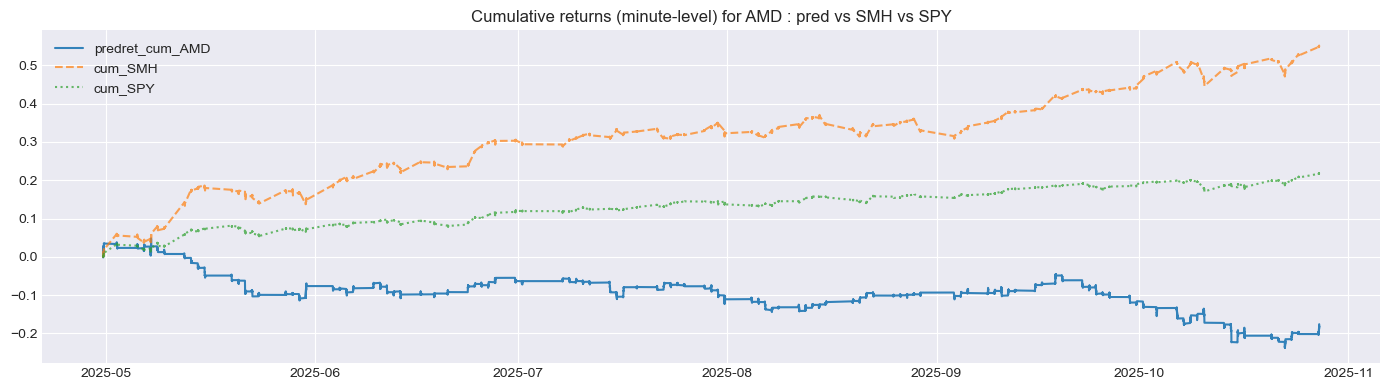

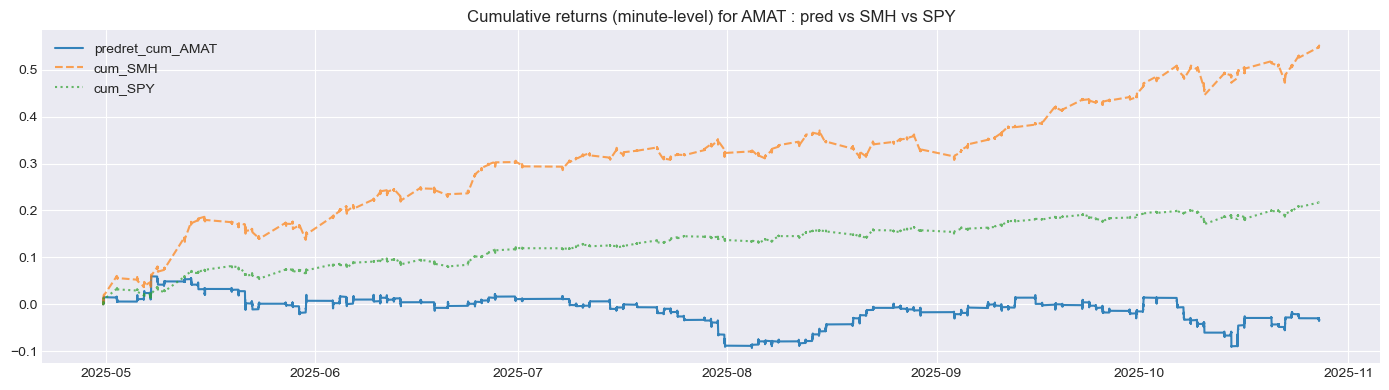

In [191]:
print("Plotting...")
plt.style.use('seaborn-v0_8-darkgrid') # 使用 'seaborn-v0_8' 风格

for s in ASSETS:
    plt.figure(figsize=(14, 4))
    plt.plot(df.index, df[f'predret_{s}'].fillna(0).cumsum(), label=f'predret_cum_{s}', alpha=0.9)
    plt.plot(df.index, df[f'ret_t_{BM1}'].fillna(0).cumsum(), label=f'cum_{BM1}', linestyle='--', alpha=0.7)
    plt.plot(df.index, df[f'ret_t_{BM2}'].fillna(0).cumsum(), label=f'cum_{BM2}', linestyle=':', alpha=0.7)
    plt.title(f"Cumulative returns (minute-level) for {s} : pred vs {BM1} vs {BM2}")
    plt.legend()
    plt.tight_layout()
    plt.show()

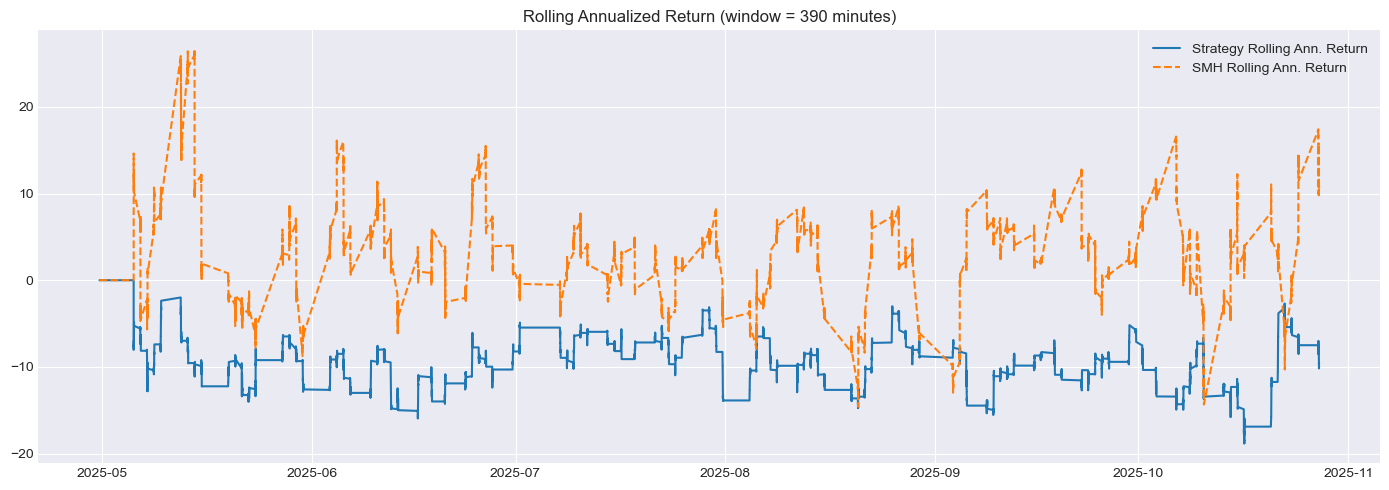

In [192]:
roll_w = FREQ_PER_DAY * 1

ann_ret_roll = df['pnl'].rolling(roll_w).mean() * periods_per_year()
bm1_roll_ret = df[f'ret_t_{BM1}'].rolling(roll_w).mean() * periods_per_year()
plt.figure(figsize=(14, 5))
plt.plot(ann_ret_roll.fillna(0), label='Strategy Rolling Ann. Return')
plt.plot(bm1_roll_ret.fillna(0), label=f'{BM1} Rolling Ann. Return', linestyle='--')
plt.title(f'Rolling Annualized Return (window = {roll_w} minutes)')
plt.legend()
plt.tight_layout()
plt.show()

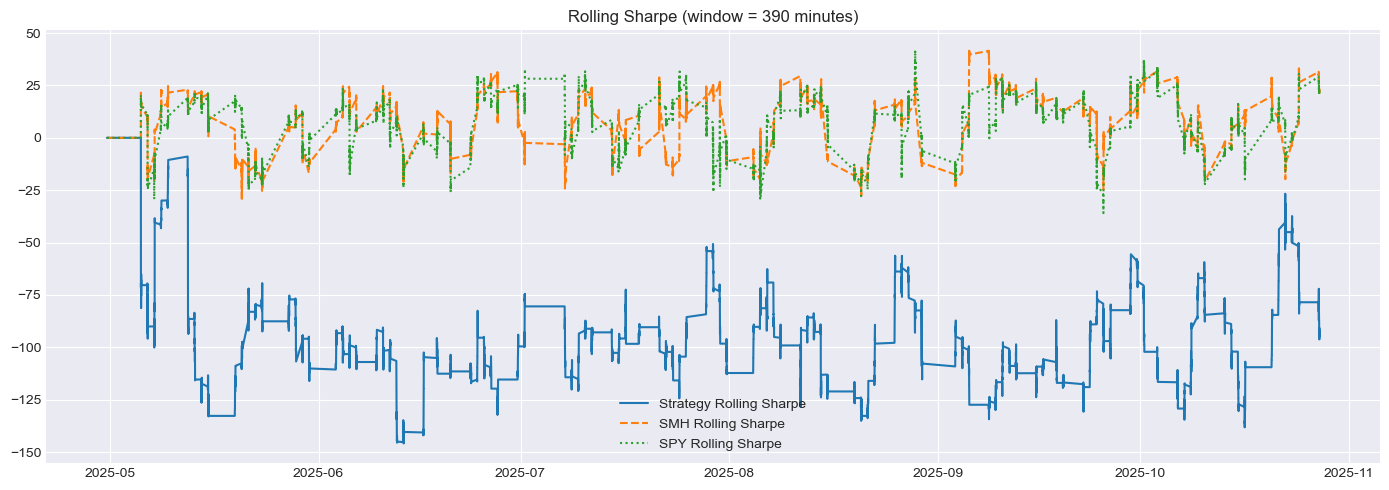

In [193]:
ann_vol_roll = df['pnl'].rolling(roll_w).std() * np.sqrt(periods_per_year())
shp_roll = (ann_ret_roll / ann_vol_roll).fillna(0)

ann_vol_roll_bm1 = df[f'ret_t_{BM1}'].rolling(roll_w).std() * np.sqrt(periods_per_year())
shp_roll_bm1 = (bm1_roll_ret / ann_vol_roll_bm1).fillna(0)

bm2_roll_ret = df[f'ret_t_{BM2}'].rolling(roll_w).mean() * periods_per_year()
ann_vol_roll_bm2 = df[f'ret_t_{BM2}'].rolling(roll_w).std() * np.sqrt(periods_per_year())
shp_roll_bm2 = (bm2_roll_ret / ann_vol_roll_bm2).fillna(0)

plt.figure(figsize=(14, 5))
plt.plot(shp_roll, label='Strategy Rolling Sharpe')
plt.plot(shp_roll_bm1, label=f'{BM1} Rolling Sharpe', linestyle='--')
plt.plot(shp_roll_bm2, label=f'{BM2} Rolling Sharpe', linestyle=':')
plt.title(f'Rolling Sharpe (window = {roll_w} minutes)')
plt.legend()
plt.tight_layout()
plt.show()

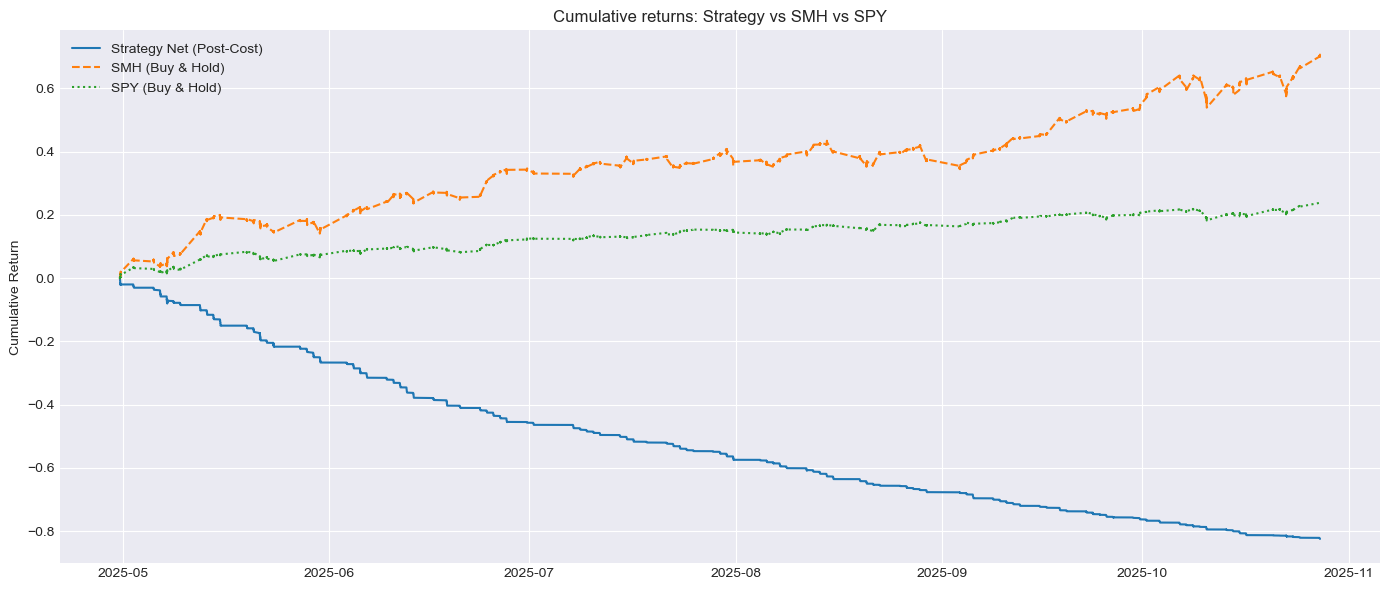

In [194]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['cum_net'], label='Strategy Net (Post-Cost)')
plt.plot(df.index, (1 + df[f'ret_t_{BM1}']).cumprod() - 1, label=f'{BM1} (Buy & Hold)', linestyle='--')
plt.plot(df.index, (1 + df[f'ret_t_{BM2}']).cumprod() - 1, label=f'{BM2} (Buy & Hold)', linestyle=':')
plt.title('Cumulative returns: Strategy vs SMH vs SPY')
plt.ylabel('Cumulative Return')
plt.legend()
plt.tight_layout()
plt.show()